# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName('Sparkify Churn Prediction').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
# change into pandas for easier workaround
dfp = df.toPandas()

In [5]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [6]:
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
dfp['page'].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
       'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object)

In [8]:
# find empty userId
dfp[dfp['userId']=='']['userId'].count()

8346

In [9]:
# what page empty userId landing on
dfp[dfp['userId']=='']['page'].unique()

array(['Home', 'Help', 'Login', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

In [10]:
dfp[dfp['userId']==''].head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
57,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
58,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
59,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
60,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
76,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,


based on analysis above there are 8346 data that have empty userId.
Look at the page they are landing on, the empty userId is because they unsuccesful to login, landing on homepage and or only search information in Help option.
We need to drop all empty userId since they never log in and we don't have hostorical data about their behavior.

#### cleaning the dataset

In [11]:
# drop empty userId
dfp = dfp[dfp['userId']!='']

In [12]:
# total user in dataset
len(dfp['userId'].unique())

225

In [13]:
# checking duplications
len(dfp),len(dfp.drop_duplicates())

(278154, 278154)

No duplication on the dataset

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
churn_users = (dfp[dfp['page']=='Cancellation Confirmation']['userId'].unique()).tolist()
dfp['churn']= np.where(dfp['userId'].isin(churn_users),1,0)

In [15]:
# Number of users that has churn
dfp.drop_duplicates(['userId']).groupby('churn')['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [16]:
def plotting_data(dfp,obj,split_by,labels):
    dfp_plot_1 = dfp.drop_duplicates(obj).groupby(split_by)['userId'].count().plot(
    kind='bar',
    title='User Distribution by Churn Level');
    dfp_plot_1.set_xticklabels(labels)

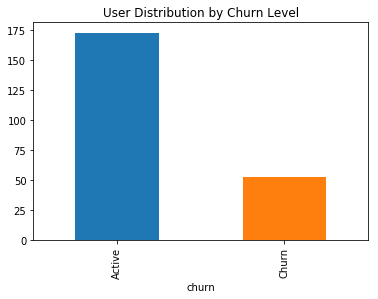

In [17]:
# Distribution of Churn users split by level
plotting_data(dfp,['userId'],['churn'],['Active','Churn'])

In [18]:
# percentage of how many people churn
(52/(52+173))*100

23.11111111111111

Based on data above, 23% of the users are Churn!

In [19]:
# number of users that has churn split by Gender
dfp.drop_duplicates(['userId','gender']).groupby(['churn','gender'])['userId'].count()

churn  gender
0      F         84
       M         89
1      F         20
       M         32
Name: userId, dtype: int64

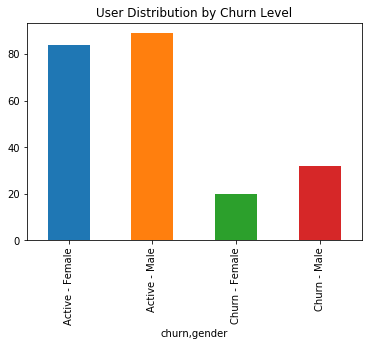

In [20]:
# Distribution of Churn users split by Gender
plotting_data(dfp,['userId','gender'],['churn','gender'],
              ['Active - Female',
               'Active - Male',
               'Churn - Female',
               'Churn - Male'])

In [21]:
# Male Churn percentage
(32/(89+32))*100

26.446280991735538

In [22]:
# Female Churn percentage
(20/(84+20))*100

19.230769230769234

Based on data above, Male Churn percentage higher than Female

In [23]:
# number of users that has churn split by Paid Status
dfp.drop_duplicates(['userId','level']).groupby(['churn','level'])['userId'].count()

churn  level
0      free     149
       paid     129
1      free      46
       paid      36
Name: userId, dtype: int64

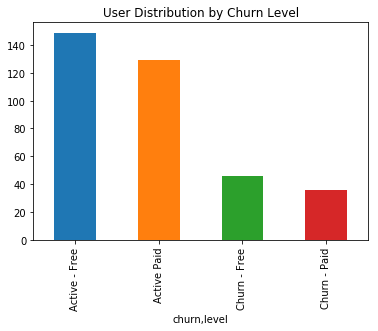

In [24]:
plotting_data(dfp,['userId','level'],['churn','level'],
              ['Active - Free',
               'Active Paid',
               'Churn - Free',
               'Churn - Paid'])

Users that using Free service churn more than paid one. This shows that paid/free services is not influencing the termination of account

In [25]:
# downgrade users
downgrade_users = (dfp[dfp['page']=='Downgrade']['userId'].unique()).tolist()
dfp['downgrade']= np.where(dfp['userId'].isin(downgrade_users),1,0)

In [26]:
dfp.drop_duplicates(['userId']).groupby('downgrade')['userId'].count()

downgrade
0     71
1    154
Name: userId, dtype: int64

In [27]:
dfp.drop_duplicates(['userId']).groupby('churn')['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

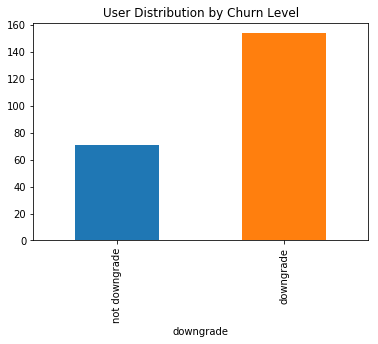

In [28]:
# Distribution of Downgrade users split by level
plotting_data(dfp,['userId'],['downgrade'],['not downgrade','downgrade'])

In [29]:
# Percentage of downgrade account
(154/(154+71))*100

68.44444444444444

In [30]:
# users that end up terminate the account after downgrading
len(set(downgrade_users)&set(churn_users))

35

In [31]:
# how many users end up churn after downgrading the account
(35/154)*100

22.727272727272727

In [32]:
# how many users churn, downgrading the account first
(35/52)*100

67.3076923076923

Majority of the users downgrade the services from Paid to Free.
23% of the downgraded users become churn.
67% churn users come from downgraded users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### OVERVIEW

Features:

- Gender of user
- The payment level (Paid/Free)
- Song length per user per session
- Number of Song Played
- Number of ThumbsUp
- Number of ThumbsDown
- Number of AddFriends
- Number of downgrades
- Number of songs per session 
- Number of Artists the user fans
- Session's duration
- Sessions' count per user
- The user's subscription age

#### Gender of User

In [33]:
dfp_features = dfp.drop_duplicates(['userId','gender','level'])[['userId','gender','level']]

In [34]:
dfp_features['gender']=np.where(dfp_features['gender']=='M',1,0)

#### Payment level

In [35]:
dfp_features['level'] = np.where(dfp_features['level']=='paid',1,0)

In [36]:
# if the user has 2 level (paid and free) choose
dfp_features = dfp_features.groupby('userId')['gender','level'].max().reset_index()

#### Total number song played

In [37]:
dfp_song = dfp.groupby(['userId'])['song'].count().reset_index()

#### Number of thumbsup

In [38]:
dfp_tu = dfp[dfp['page']=='Thumbs Up'].groupby(['userId']).size().reset_index(name='thumbsup')

#### Number of Thumbs Down

In [39]:
dfp_td = dfp[dfp['page']=='Thumbs Down'].groupby(['userId']).size().reset_index(name='thumbsdown')

#### Add Friends

In [40]:
dfp_add = dfp[dfp['page']=='Add Friend'].groupby(['userId']).size().reset_index(name='add_friend')

#### Number of Downgrades

In [41]:
dfp_dg = dfp[['userId','downgrade']].drop_duplicates()

#### Number of Songs per Session

In [42]:
dfp_ses_song =dfp.groupby(['userId','sessionId'])['song'].count().reset_index()
dfp_ses_song_avg = dfp_ses_song.groupby('userId')['song'].mean().reset_index(name='song_persession')

#### Number of Artists the User fans

In [43]:
dfp_artist = dfp.groupby(['userId'])['artist'].nunique().reset_index(name='artist')

#### Session's Duration

In [44]:
dfp_max_ts = dfp.groupby(['userId','sessionId'])['ts'].max().reset_index(name='max ts')
dfp_min_ts = dfp.groupby(['userId','sessionId'])['ts'].min().reset_index(name='min ts')
dfp_ses_dur = pd.merge(dfp_max_ts,dfp_min_ts, left_on=['userId','sessionId'],right_on=['userId','sessionId'],how='left')

In [45]:
dfp_ses_dur['duration'] = dfp_ses_dur['max ts'] - dfp_ses_dur['min ts']

In [46]:
ticks_per_hour = 1000*60*60
dfp_ses_dur['duration_hour'] =  dfp_ses_dur['duration']/ticks_per_hour

In [47]:
dfp_ses_dur_avg = dfp_ses_dur.groupby(['userId'])['duration_hour'].mean().reset_index(name='avg_duration_hour')

#### session count per user

In [48]:
dfp_num_session = dfp.groupby('userId')['sessionId'].nunique().reset_index(name='num_sessions')

#### user subscription age

In [49]:
dfp_registration = dfp[['userId','registration']].drop_duplicates()
dfp_last_ts = dfp.groupby('userId')['ts'].max().reset_index(name='last_ts')
dfp_subs_age = pd.merge(dfp_registration,dfp_last_ts,left_on='userId',right_on='userId',how='left')
dfp_subs_age['subs_age'] = (dfp_subs_age['last_ts']) - (dfp_subs_age['registration'])
ticks_per_day = 1000*60*60*24
dfp_subs_age['subs_age_days'] = dfp_subs_age['subs_age']/ticks_per_day
dfp_subs_age = dfp_subs_age[dfp_subs_age['userId']!='']

In [50]:
dfp_subs_age = dfp_subs_age[['userId','subs_age_days']]

#### churn

In [51]:
dfp_churn = dfp[['userId','churn']].drop_duplicates()

#### Number of days as free/paid user

In [52]:
dfps = [dfp_churn,dfp_features,dfp_add,dfp_artist,dfp_dg,dfp_song,dfp_tu,dfp_td,dfp_ses_song_avg,dfp_ses_dur_avg,dfp_num_session,dfp_subs_age]

In [53]:
dfp_final = reduce(lambda x,y: pd.merge(x,y, on='userId', how='outer'), dfps)

In [54]:
dfp_final = dfp_final.fillna(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [55]:
dfp_final = dfp_final.rename(columns={'churn':'label'})

In [56]:
dfp_final.head()

,userId,label,gender,level,add_friend,artist,downgrade,song,thumbsup,thumbsdown,song_persession,avg_duration_hour,num_sessions,subs_age_days
0,30,0,1,1,25.0,1018,1,1417,62.0,17.0,44.281250,3.059905,32,63.066644
1,9,0,1,1,40.0,1672,1,2676,118.0,32.0,86.322581,5.876281,31,60.832431
2,74,0,0,1,43.0,1557,1,2400,135.0,25.0,104.347826,7.211473,23,71.223461
3,54,1,0,1,33.0,1744,1,2841,163.0,29.0,76.783784,5.371494,37,110.751690
4,4,0,1,1,46.0,1342,1,2048,95.0,26.0,93.090909,6.322311,22,62.797743


In [57]:
dfp_final.to_csv('sparkify_data_input.csv',index=False)

In [58]:
input_df = spark.read.csv('sparkify_data_input.csv', header=True)

In [59]:
input_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- add_friend: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- downgrade: string (nullable = true)
 |-- song: string (nullable = true)
 |-- thumbsup: string (nullable = true)
 |-- thumbsdown: string (nullable = true)
 |-- song_persession: string (nullable = true)
 |-- avg_duration_hour: string (nullable = true)
 |-- num_sessions: string (nullable = true)
 |-- subs_age_days: string (nullable = true)



In [60]:
from pyspark.sql import types as sT

# integer 
int_cols = ['userId','label','gender','level','num_sessions']
for col in int_cols:
    input_df = input_df.withColumn(col,input_df[col].cast(sT.IntegerType()))

In [61]:
# float
float_cols = ['add_friend','song','thumbsup','thumbsdown','downgrade','artist','song_persession','avg_duration_hour','subs_age_days']
for col in float_cols:
    input_df = input_df.withColumn(col,input_df[col].cast(sT.FloatType()))

In [62]:
input_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- artist: float (nullable = true)
 |-- downgrade: float (nullable = true)
 |-- song: float (nullable = true)
 |-- thumbsup: float (nullable = true)
 |-- thumbsdown: float (nullable = true)
 |-- song_persession: float (nullable = true)
 |-- avg_duration_hour: float (nullable = true)
 |-- num_sessions: integer (nullable = true)
 |-- subs_age_days: float (nullable = true)



In [63]:
features_col = ['gender',
 'level',
 'add_friend',
 'artist',
 'downgrade',
 'song',
 'thumbsup',
 'thumbsdown',
 'song_persession',
 'avg_duration_hour',
 'num_sessions',
 'subs_age_days']

In [64]:
train,test = input_df.randomSplit([0.8,0.2], seed=55)

In [65]:
from pyspark.ml.feature import MinMaxScaler
assembler = VectorAssembler(inputCols=features_col, outputCol="features_vector")
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")

In [66]:
assembler

VectorAssembler_f04b92815435

### Logistic Regression

In [67]:
lr =  LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=10, regParam=0.0, elasticNetParam=0)

In [68]:
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

In [69]:
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1]).build()

In [70]:
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [71]:
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics
results_lr = cvModel_lr.transform(test)

In [72]:
print("Accuracy for Logistic Regression Model is: ", results_lr.filter(results_lr.label == results_lr.prediction).count()/ results_lr.count())
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_lr)
print("F1 score for Logistic Regression model is : ", score)

Accuracy for Logistic Regression Model is:  0.8333333333333334
F1 score for Logistic Regression model is :  0.7976190476190476


In [73]:
cvModel_lr.bestModel.stages[-1].coefficients

DenseVector([0.0671, 0.0417, -0.8321, -0.0001, 0.5993, -0.2133, -0.4505, 0.9866, -0.2713, -0.1502, -0.014, -0.9164])

Text(0.5,1,'Logistic Regression Model Feature Distribution')

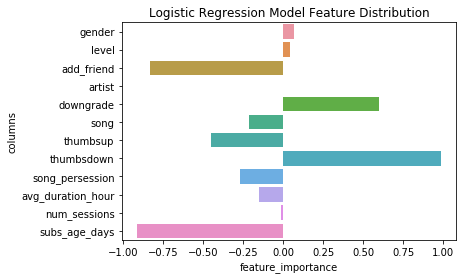

In [74]:
feature_importances = cvModel_lr.bestModel.stages[-1].coefficients.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': features_col})
graph = sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)
graph.set_title('Logistic Regression Model Feature Distribution')

In [75]:
feature_importance_df

,feature_importance,columns
0,0.067132,gender
1,0.041662,level
2,-0.832113,add_friend
3,-0.000108,artist
4,0.599302,downgrade
5,-0.213325,song
6,-0.450528,thumbsup
7,0.986647,thumbsdown
8,-0.271347,song_persession
9,-0.150176,avg_duration_hour


looking at the graph above, the most important factor for the churn is thumbsdown, and subs age days

### Random Forest Classifier

In [76]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 3, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics
results_rf = cvModel_rf.transform(test)
print("Accuracy for Random Forest Model is: ", results_rf.filter(results_rf.label == results_rf.prediction).count()/ results_rf.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_rf)
print("F1 score for Random Forest Model is: ", score)

Accuracy for Random Forest Model is:  0.7916666666666666
F1 score for Random Forest Model is:  0.7916666666666667


In [77]:
print("The best value for number of trees is: ", cvModel_rf.bestModel.stages[-1]._java_obj.parent().getNumTrees())

The best value for number of trees is:  10


In [78]:
cvModel_rf.bestModel.stages[2].featureImportances

SparseVector(12, {0: 0.0235, 2: 0.0495, 3: 0.0302, 5: 0.1269, 6: 0.084, 7: 0.1695, 8: 0.0455, 9: 0.0903, 10: 0.0506, 11: 0.33})

In [82]:
features_col_gbt = [
 'gender',
#  'level',
 'add_friend',
 'artist',
#  'downgrade',
 'song',
 'thumbsup',
 'thumbsdown',
 'song_persession',
 'avg_duration_hour',
 'num_sessions',
 'subs_age_days']

In [83]:
cvModel_rf.bestModel.stages[2].featureImportances

SparseVector(12, {0: 0.0235, 2: 0.0495, 3: 0.0302, 5: 0.1269, 6: 0.084, 7: 0.1695, 8: 0.0455, 9: 0.0903, 10: 0.0506, 11: 0.33})

Text(0.5,1,'Random Forest Classifier Feature Distribution')

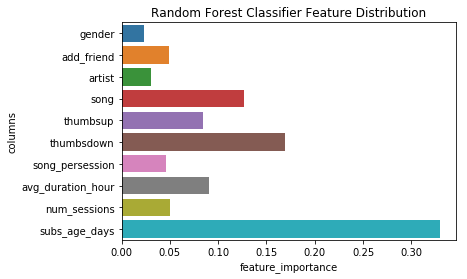

In [84]:
feature_importances = cvModel_rf.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': features_col_gbt})
graph = sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)
graph.set_title('Random Forest Classifier Feature Distribution')

### Gradient Boosting Tree Classifier

In [85]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[5,3, 10]) \
    .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3, collectSubModels=True)
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics
results_gbt = cvModel_gbt.transform(test)
print("Accuracy for Gradient Boosting Tree Model is: ", results_gbt.filter(results_gbt.label == results_gbt.prediction).count()/ results_gbt.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_gbt)
print("F1 score for Gradient Boosting Tree classifier is : ", score)

Accuracy for Gradient Boosting Tree Model is:  0.7291666666666666
F1 score for Gradient Boosting Tree classifier is :  0.7430952380952381


In [86]:
print("The best value for maximum number of iterations is: ", cvModel_gbt.bestModel.stages[-1]._java_obj.parent().getMaxIter())

The best value for maximum number of iterations is:  5


In [87]:
cvModel_gbt.bestModel.stages[2].featureImportances

SparseVector(12, {0: 0.0187, 2: 0.1281, 3: 0.1529, 5: 0.0037, 6: 0.1288, 7: 0.1855, 8: 0.0425, 9: 0.0703, 10: 0.0342, 11: 0.2353})

In [88]:
cvModel_gbt.bestModel.stages[2].featureImportances.values

array([ 0.0186836 ,  0.12805455,  0.15294042,  0.00368923,  0.12883662,
        0.18554673,  0.04252496,  0.07025251,  0.03419114,  0.23528023])

In [89]:
input_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- artist: float (nullable = true)
 |-- downgrade: float (nullable = true)
 |-- song: float (nullable = true)
 |-- thumbsup: float (nullable = true)
 |-- thumbsdown: float (nullable = true)
 |-- song_persession: float (nullable = true)
 |-- avg_duration_hour: float (nullable = true)
 |-- num_sessions: integer (nullable = true)
 |-- subs_age_days: float (nullable = true)



In [90]:
cvModel_gbt.bestModel.stages[2].featureImportances

SparseVector(12, {0: 0.0187, 2: 0.1281, 3: 0.1529, 5: 0.0037, 6: 0.1288, 7: 0.1855, 8: 0.0425, 9: 0.0703, 10: 0.0342, 11: 0.2353})

In [91]:
features_col_gbt = [
 'gender',
#  'level',
 'add_friend',
 'artist',
#  'downgrade',
 'song',
 'thumbsup',
 'thumbsdown',
 'song_persession',
 'avg_duration_hour',
 'num_sessions',
 'subs_age_days']

Text(0.5,1,'Gradient Boosting Tree Classifier Feature Distribution')

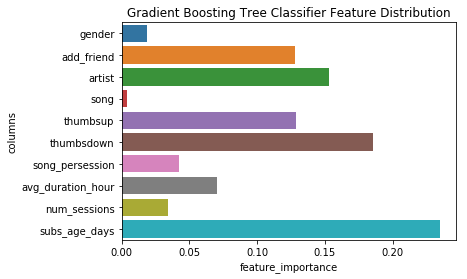

In [92]:
feature_importances = cvModel_gbt.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': features_col_gbt})
graph = sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)
graph.set_title('Gradient Boosting Tree Classifier Feature Distribution')

Thumbsdown and subs_age_days  is the most important feature in Gradient Boosting Tree

### Conclusion

I use 12 features to predict users churn. Both method, Logistic Regression and Gradient Boosting Tree shows that two most important features are Thumbsdown and Duration of User Subscribe the Sparkify.
I try 3 methods for modeling that are : Logistic Regression,Random Forest Classifier, and Gradient Boosting Tree.
Based on the F1-Score, Logistic Regression is the most fittable for this case with F1-Score  0.7976190476190476

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.